# Setup of Main


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



# Data generation for the copy task.
def generate_copy_data(num_samples, T, vocab_size):
    """
    For each sample:
      - Generate a random sequence of length T (tokens from 1 to vocab_size).
      - Build input: [sequence] + [delimiter token] + [T blank tokens (0)]
      - Build target: [T+1 blanks] + [the original sequence]
    """
    seq_length = 2 * T + 1
    X = np.zeros((num_samples, seq_length), dtype=np.int32)
    Y = np.zeros((num_samples, seq_length), dtype=np.int32)
    delimiter_token = vocab_size + 1  # special delimiter token
    for i in range(num_samples):
        # Random sequence of T tokens (range: 1 to vocab_size)
        random_seq = np.random.randint(1, vocab_size + 1, size=T)
        # Input: first T tokens are the sequence, then a delimiter, then T blanks (0)
        X[i, :T] = random_seq
        X[i, T] = delimiter_token
        X[i, T+1:] = 0
        # Target: first T+1 positions are blanks (0), last T positions are the sequence
        Y[i, :T+1] = 0
        Y[i, T+1:] = random_seq
    print(f"X shape: {X[0]}, Y shape: {Y[0]}")
    return X, Y

# Hyperparameters
num_samples = 1000    # total examples
T = 20                # sequence length to copy (experiment with larger values as needed)
vocab_size = 10       # tokens 1..10 (e.g., representing letters a-j)
hidden_size = 64
batch_size = 64
epochs = 10

delimiter_token = vocab_size + 1  # used for both data generation and model processing
blank_token = 0

# Generate the copy task data.
X, Y = generate_copy_data(num_samples, T, vocab_size)

# Split into training (70%) and validation (30%).
split_index = int(0.7 * num_samples)
X_train, Y_train = X[:split_index], Y[:split_index]
X_val, Y_val = X[split_index:], Y[split_index:]

# Create tf.data.Dataset objects.
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size)


X shape: [ 4  5  6  9  2  6  4  4  7  3  9  5  4  9  8  7  9  8  1  3 11  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], Y shape: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 5 6 9 2 6 4 4 7 3 9 5 4 9 8 7
 9 8 1 3]


# STD LSTM (tensorflow)

In [ ]:
class STDLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(STDLSTMCell, self).__init__()
        self.units = units
        # Define the state size: hidden state and cell state.
        self.state_size = [self.units, self.units]
        self.output_size = self.units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Input gate weights and bias
        self.W_i = self.add_weight(shape=(input_dim, self.units), initializer='random_normal', trainable=True)
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer='random_normal', trainable=True)
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
        # Forget gate weights and bias
        self.W_f = self.add_weight(shape=(input_dim, self.units), initializer='random_normal', trainable=True)
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer='random_normal', trainable=True)
        self.b_f = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
        # Output gate weights and bias
        self.W_o = self.add_weight(shape=(input_dim, self.units), initializer='random_normal', trainable=True)
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer='random_normal', trainable=True)
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
        # Candidate cell state weights and bias
        self.W_c = self.add_weight(shape=(input_dim, self.units), initializer='random_normal', trainable=True)
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer='random_normal', trainable=True)
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)

    def call(self, x, states):
        h_prev, c_prev = states

        # Input gate: i_t = sigmoid(W_i * x_t + U_i * h_(t-1) + b_i)
        i = tf.sigmoid(tf.matmul(x, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        # Forget gate: f_t = sigmoid(W_f * x_t + U_f * h_(t-1) + b_f)
        f = tf.sigmoid(tf.matmul(x, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        # Output gate: o_t = sigmoid(W_o * x_t + U_o * h_(t-1) + b_o)
        o = tf.sigmoid(tf.matmul(x, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        # Candidate cell state: c̃_t = tanh(W_c * x_t + U_c * h_(t-1) + b_c)
        c_hat = tf.tanh(tf.matmul(x, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        # New cell state: c_t = f_t ⊙ c_(t-1) + i_t ⊙ c̃_t
        c = f * c_prev + i * c_hat
        # New hidden state: h_t = o_t ⊙ tanh(c_t)
        h = o * tf.tanh(c)

        return h, [h, c]

# Custom LSTM model that uses the above custom cell.
class STDLSTMModel(tf.keras.Model):
    def __init__(self, vocab_size, hidden_size):
        super(STDLSTMModel, self).__init__()
        # The embedding layer maps input tokens to vectors.
        # We use vocab_size+2 because token 0 is blank and token (vocab_size+1) is the delimiter.
        self.embedding = tf.keras.layers.Embedding(vocab_size + 2, hidden_size)
        # Wrap the custom LSTM cell with tf.keras.layers.RNN.
        self.rnn = tf.keras.layers.RNN(STDLSTMCell(hidden_size), return_sequences=True, return_state=True)
        # Dense layer to project RNN outputs to (vocab_size+1) probabilities.
        self.dense = tf.keras.layers.Dense(vocab_size + 1, activation='softmax')

    def call(self, inputs, initial_state=None, training=False):
        x = self.embedding(inputs)
        if initial_state is None:
            rnn_out, h, c = self.rnn(x)
        else:
            rnn_out, h, c = self.rnn(x, initial_state=initial_state)
        output = self.dense(rnn_out)
        return output

Train the Model

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4860 - loss: 2.3375 - val_accuracy: 0.5567 - val_loss: 1.9727
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5561 - loss: 1.7115 - val_accuracy: 0.5507 - val_loss: 1.2961
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5531 - loss: 1.2564 - val_accuracy: 0.5581 - val_loss: 1.1770
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5602 - loss: 1.1687 - val_accuracy: 0.5589 - val_loss: 1.1568
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5579 - loss: 1.1540 - val_accuracy: 0.5607 - val_loss: 1.1494
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5599 - loss: 1.1475 - val_accuracy: 0.5608 - val_loss: 1.1447
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5592 - loss: 1.1433 - val_accuracy: 0.5604 - val_loss: 1.1411
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5610 - loss: 1.1398 - val_accuracy: 0.5603 - v

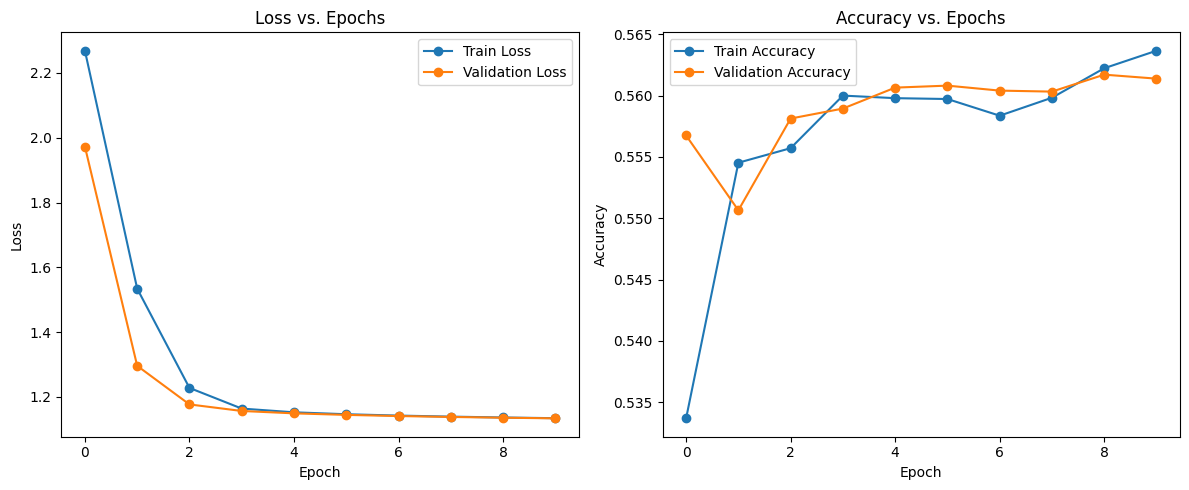

In [ ]:
# Instantiate and compile the custom LSTM model.
custom_model = STDLSTMModel(vocab_size, hidden_size)
custom_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model.
history = custom_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

# Plot training loss and accuracy.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# MUL LSTM (tensorflow)

In [ ]:
class MLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(MLSTMCell, self).__init__()
        self.units = units
        # State size: hidden state (h) and cell state (c).
        self.state_size = [self.units, self.units]
        self.output_size = self.units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # -- Multiplicative term parameters: m_t = W_m x_t + U_m h_(t-1) + b_m --
        # Produces a vector of size [batch_size, input_dim], which is then
        # elementwise-multiplied with x_t to form x̃_t.
        self.W_m = self.add_weight( shape=(input_dim, input_dim), initializer="random_normal", trainable=True, name="W_m",)
        self.U_m = self.add_weight( shape=(self.units, input_dim), initializer="random_normal", trainable=True, name="U_m",)
        self.b_m = self.add_weight( shape=(input_dim,), initializer="zeros", trainable=True, name="b_m")

        # -- LSTM gate parameters (same shapes as standard LSTM) --
        # Input gate
        self.W_i = self.add_weight( shape=(input_dim, self.units), initializer="random_normal", trainable=True, name="W_i",)
        self.U_i = self.add_weight( shape=(self.units, self.units), initializer="random_normal", trainable=True, name="U_i",)
        self.b_i = self.add_weight( shape=(self.units,), initializer="zeros", trainable=True, name="b_i")

        # Forget gate
        self.W_f = self.add_weight( shape=(input_dim, self.units), initializer="random_normal", trainable=True, name="W_f",)
        self.U_f = self.add_weight( shape=(self.units, self.units), initializer="random_normal", trainable=True, name="U_f",)
        self.b_f = self.add_weight( shape=(self.units,), initializer="zeros", trainable=True, name="b_f")

        # Output gate
        self.W_o = self.add_weight( shape=(input_dim, self.units), initializer="random_normal", trainable=True, name="W_o",)
        self.U_o = self.add_weight( shape=(self.units, self.units), initializer="random_normal", trainable=True, name="U_o",)
        self.b_o = self.add_weight( shape=(self.units,), initializer="zeros", trainable=True, name="b_o")

        # Candidate cell state
        self.W_c = self.add_weight( shape=(input_dim, self.units), initializer="random_normal", trainable=True, name="W_c",)
        self.U_c = self.add_weight( shape=(self.units, self.units), initializer="random_normal", trainable=True, name="U_c",)
        self.b_c = self.add_weight( shape=(self.units,), initializer="zeros", trainable=True, name="b_c")

    def call(self, x, states):
        """
        x:      [batch_size, input_dim]
        states: [h_prev, c_prev], each of shape [batch_size, units]
        """
        h_prev, c_prev = states
        #  m_t = W_m * x + U_m * h_prev + b_m
        m_t = tf.matmul(x, self.W_m) + tf.matmul(h_prev, self.U_m) + self.b_m
        #  x̃_t = m_t ⊙ x
        x_tilde = m_t * x  # shape: [batch_size, input_dim]
        # Input gate: i_t
        i = tf.sigmoid(tf.matmul(x_tilde, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        # Forget gate: f_t
        f = tf.sigmoid(tf.matmul(x_tilde, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        # Output gate: o_t
        o = tf.sigmoid(tf.matmul(x_tilde, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        # Candidate cell state: c̃_t
        c_hat = tf.tanh(tf.matmul(x_tilde, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        # New cell state: c_t
        c = f * c_prev + i * c_hat
        # New hidden state: h_t
        h = o * tf.tanh(c)
        return h, [h, c]

class MLSTMModel(tf.keras.Model):
    def __init__(self, vocab_size, hidden_size):
        super(MLSTMModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size + 2, hidden_size)
        self.rnn = tf.keras.layers.RNN(
            MLSTMCell(hidden_size),
            return_sequences=True,
            return_state=True
        )
        # Dense layer to project RNN outputs to (vocab_size+1) probabilities.
        self.dense = tf.keras.layers.Dense(vocab_size + 1, activation='softmax')

    def call(self, inputs, initial_state=None, training=False):
        x = self.embedding(inputs)
        if initial_state is None:
            rnn_out, h, c = self.rnn(x)  # automatically uses zeros if no init state
        else:
            rnn_out, h, c = self.rnn(x, initial_state=initial_state)
        output = self.dense(rnn_out)
        return output

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.4196 - loss: 2.3888 - val_accuracy: 0.5122 - val_loss: 2.3462
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5156 - loss: 2.2972 - val_accuracy: 0.5495 - val_loss: 1.8860
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5446 - loss: 1.6722 - val_accuracy: 0.5580 - val_loss: 1.2768
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5592 - loss: 1.2392 - val_accuracy: 0.5611 - val_loss: 1.1705
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5603 - loss: 1.1630 - val_accuracy: 0.5581 - val_loss: 1.1479
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5598 - loss: 1.1442 - val_accuracy: 0.5601 - val_loss: 1.1367
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5614 - loss: 1.1348 - val_accuracy: 0.5594 - val_loss: 1.1321
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5619 - loss: 1.1307 - val_accuracy: 0.5589 - v

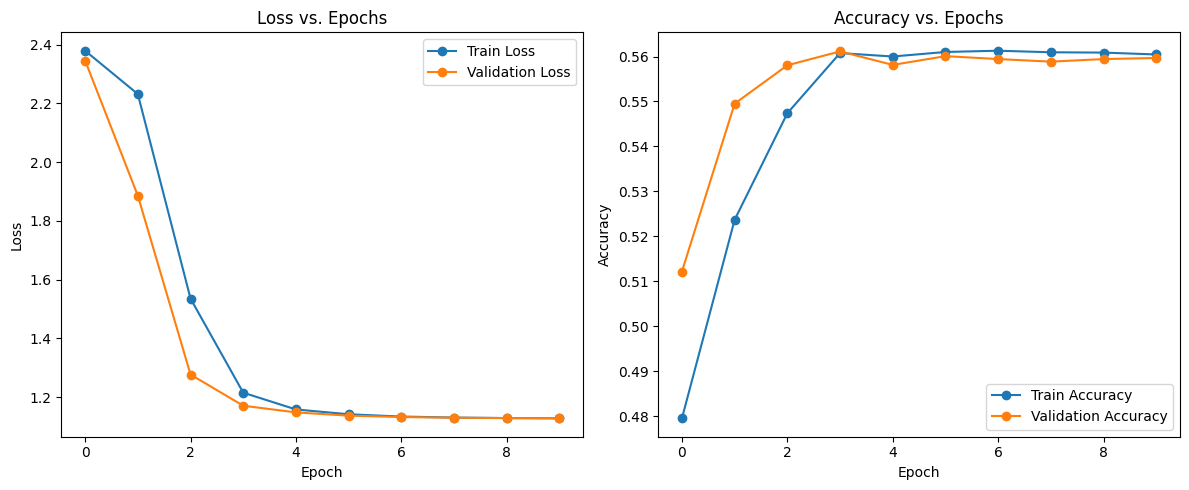

In [ ]:
# Instantiate and compile the custom LSTM model.
custom_model = MLSTMModel(vocab_size, hidden_size)
custom_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model.
history = custom_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

# Plot training loss and accuracy.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# STD GRU (tensorflow)

In [9]:
class StandardGRUCell(tf.keras.layers.Layer):
    """
    A custom implementation of the standard GRU cell using TensorFlow.
    Equations:
        z_t = sigma(W_z * x_t + U_z * h_{t-1} + b_z)
        r_t = sigma(W_r * x_t + U_r * h_{t-1} + b_r)
        h_tilde = tanh(W_h * x_t + U_h * (r_t * h_{t-1}) + b_h)
        h_t = (1 - z_t) * h_{t-1} + z_t * h_tilde
    """
    def __init__(self, units, **kwargs):
        super(StandardGRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = units  # <-- This line defines the state size

    def build(self, input_shape):
        # input_shape is (batch_size, input_dim)
        input_dim = input_shape[-1]
        self.Wz = self.add_weight( shape=(input_dim, self.units), initializer='glorot_uniform', name='Wz' )
        self.Uz = self.add_weight( shape=(self.units, self.units), initializer='orthogonal', name='Uz' )
        self.bz = self.add_weight( shape=(self.units,), initializer='zeros', name='bz' )
        # Weights for reset gate r
        self.Wr = self.add_weight( shape=(input_dim, self.units), initializer='glorot_uniform', name='Wr' )
        self.Ur = self.add_weight( shape=(self.units, self.units), initializer='orthogonal', name='Ur' )
        self.br = self.add_weight( shape=(self.units,), initializer='zeros', name='br' )
        # Weights for candidate hidden state h_tilde
        self.Wh = self.add_weight( shape=(input_dim, self.units), initializer='glorot_uniform', name='Wh' )
        self.Uh = self.add_weight( shape=(self.units, self.units), initializer='orthogonal', name='Uh' )
        self.bh = self.add_weight( shape=(self.units,), initializer='zeros', name='bh' )
        super(StandardGRUCell, self).build(input_shape)

    def call(self, inputs, states):
        """
        inputs: (batch_size, input_dim)
        states: list with a single element h_{t-1} of shape (batch_size, units)
        """
        h_prev = states[0]
        z_t = tf.sigmoid( tf.matmul(inputs, self.Wz) + tf.matmul(h_prev, self.Uz) + self.bz )
        # Reset gate r_t
        r_t = tf.sigmoid( tf.matmul(inputs, self.Wr) + tf.matmul(h_prev, self.Ur) + self.br )
        # Candidate hidden state h_tilde
        h_tilde = tf.tanh( tf.matmul(inputs, self.Wh) + tf.matmul(r_t * h_prev, self.Uh) + self.bh )
        # Final new hidden state h_t
        h_t = (1 - z_t) * h_prev + z_t * h_tilde
        return h_t, [h_t]


class StandardGRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, **kwargs):
        super(StandardGRUModel, self).__init__(**kwargs)
        # Embedding layer for converting token IDs to dense vectors.
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        # Wrap the custom GRU cell in an RNN layer.
        self.rnn = tf.keras.layers.RNN(StandardGRUCell(units), return_sequences=True)
        # Dense layer to project the RNN outputs to the vocabulary size.
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        """
        Forward pass of the model.

        Args:
            inputs: Tensor of shape (batch_size, sequence_length) containing token IDs.
            training: Boolean flag for training mode.

        Returns:
            Tensor of shape (batch_size, sequence_length, vocab_size) with logits.
        """
        # Convert token IDs to embeddings.
        x = self.embedding(inputs)  # (batch_size, sequence_length, embedding_dim)
        # Process the sequence with the custom GRU cell.
        x = self.rnn(x)             # (batch_size, sequence_length, units)
        # Project the GRU outputs to the vocabulary space.
        logits = self.dense(x)      # (batch_size, sequence_length, vocab_size)
        return logits

Training the model

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.4115 - loss: 2.3621 - val_accuracy: 0.5567 - val_loss: 1.8075
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5516 - loss: 1.6074 - val_accuracy: 0.5537 - val_loss: 1.3079
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5529 - loss: 1.2696 - val_accuracy: 0.5605 - val_loss: 1.1834
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5571 - loss: 1.1746 - val_accuracy: 0.5615 - val_loss: 1.1584
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5629 - loss: 1.1535 - val_accuracy: 0.5594 - val_loss: 1.1442
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5602 - loss: 1.1414 - val_accuracy: 0.5614 - val_loss: 1.1370
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5617 - loss: 1.1357 - val_accuracy: 0.5575 - val_loss: 1.1343
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5626 - loss: 1.1326 - val_accuracy: 0.5585 - 

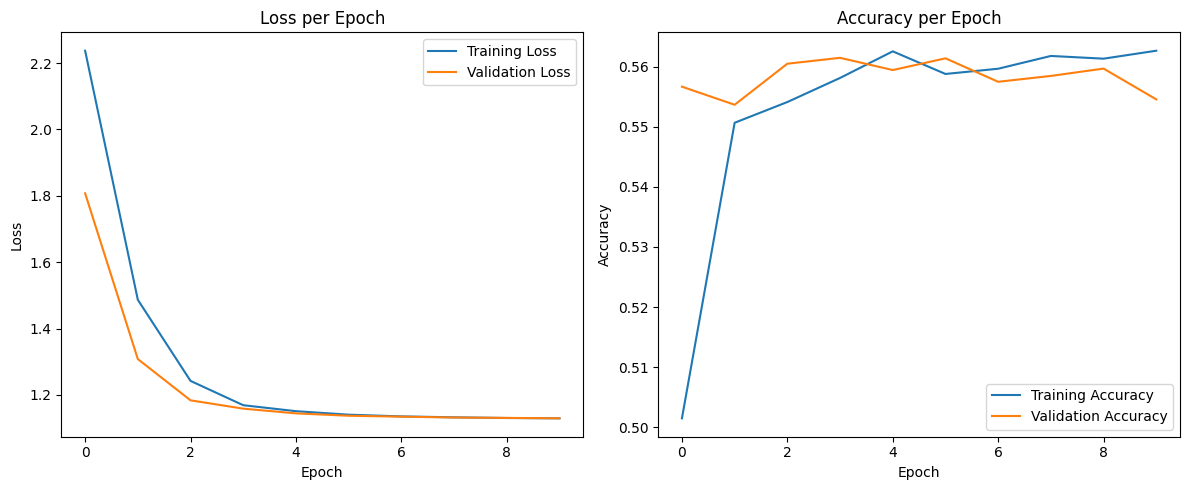

In [10]:
# Define an embedding dimension (can be chosen independently from hidden_size)
embedding_dim = 32  # you can experiment with different values

# Create an instance of your StandardGRUModel.
# Note: Since your data uses tokens 0 ... vocab_size+1, we pass vocab_size+2.
model = StandardGRUModel(vocab_size+2, embedding_dim, hidden_size)

# Compile the model with an optimizer, loss function, and accuracy metric.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model using model.fit. The history object will store training and validation metrics.
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

# Plot the training and validation loss and accuracy.
plt.figure(figsize=(12, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# MUL GRU (tensorflow)

In [13]:
class MultiplicativeGRUCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(MultiplicativeGRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = units  # <-- Added to satisfy RNN requirements

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.Wm = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wm')
        self.Um = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Um')
        self.bm = self.add_weight(shape=(self.units,), initializer='zeros', name='bm')

        self.Wz = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='Wz')
        self.Uz = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uz')
        self.bz = self.add_weight(shape=(self.units,), initializer='zeros', name='bz')

        self.Wr = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='Wr')
        self.Ur = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Ur')
        self.br = self.add_weight(shape=(self.units,), initializer='zeros', name='br')

        self.Wh = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='Wh')
        self.Uh = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uh')
        self.bh = self.add_weight(shape=(self.units,), initializer='zeros', name='bh')

        self.input_dim = input_dim

        super(MultiplicativeGRUCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]

        m_t = tf.matmul(inputs, self.Wm) + tf.matmul(h_prev, self.Um) + self.bm
        x_tilde = m_t * inputs
        z_t = tf.sigmoid(tf.matmul(x_tilde, self.Wz) + tf.matmul(h_prev, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(x_tilde, self.Wr) + tf.matmul(h_prev, self.Ur) + self.br)
        h_tilde = tf.tanh(tf.matmul(x_tilde, self.Wh) + tf.matmul(r_t * h_prev, self.Uh) + self.bh)
        h_t = (1 - z_t) * h_prev + z_t * h_tilde
        return h_t, [h_t]


class MultiplicativeGRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, **kwargs):
        super(MultiplicativeGRUModel, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.units = units

        # Embedding layer to convert token IDs into dense vectors.
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)

        # If the embedding dimension is not equal to the cell units,
        # add a projection layer to transform embeddings to the desired dimension.
        if embedding_dim != units:
            self.projection = tf.keras.layers.Dense(units)
        else:
            self.projection = None

        # Wrap the custom Multiplicative GRU cell inside an RNN layer.
        self.rnn = tf.keras.layers.RNN(MultiplicativeGRUCell(units), return_sequences=True)

        # Final dense layer to project the RNN outputs to the vocabulary space.
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        """
        Args:
            inputs: Tensor of shape (batch_size, sequence_length) containing token IDs.
            training: Boolean flag for training mode.

        Returns:
            logits: Tensor of shape (batch_size, sequence_length, vocab_size).
        """
        # Convert token IDs to embeddings.
        x = self.embedding(inputs)  # (batch_size, sequence_length, embedding_dim)

        # Optionally project embeddings if dimensions differ.
        if self.projection is not None:
            x = self.projection(x)  # (batch_size, sequence_length, units)

        # Process the sequence with the custom multiplicative GRU cell.
        x = self.rnn(x)  # (batch_size, sequence_length, units)

        # Project the GRU outputs to the vocabulary.
        logits = self.dense(x)  # (batch_size, sequence_length, vocab_size)
        return logits

Train the model

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.0497 - loss: nan - val_accuracy: 0.0478 - val_loss: nan
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0501 - loss: nan - val_accuracy: 0.0478 - val_loss: nan
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0487 - loss: nan - val_accuracy: 0.0478 - val_loss: nan
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0502 - loss: nan - val_accuracy: 0.0478 - val_loss: nan
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0486 - loss: nan - val_accuracy: 0.0478 - val_loss: nan
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0486 - loss: nan - val_accuracy: 0.0478 - val_loss: nan
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0478 - loss: nan - val_accuracy: 0.0478 - val_loss: nan
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0488 - loss: nan - val_accuracy: 0.0478 - val_loss: nan
Epoch 9/10
11/11 ━━━━━━━━━━━━━━

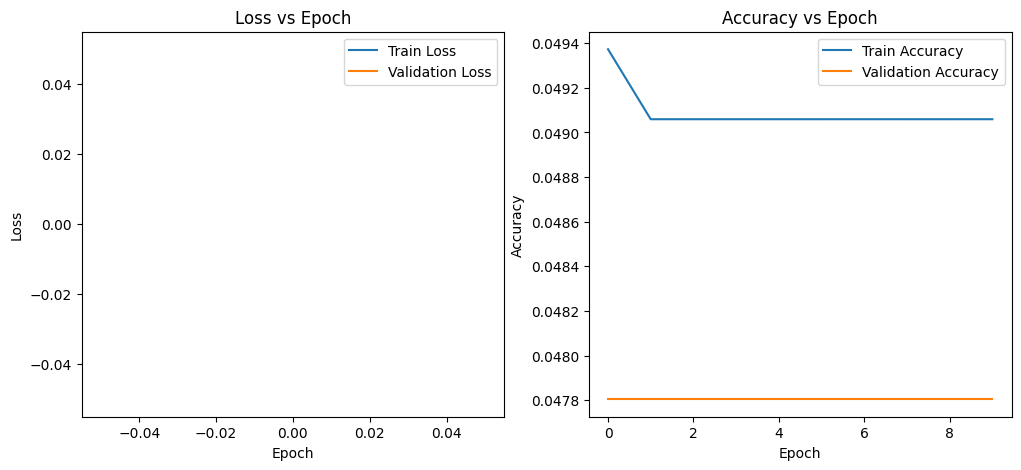

In [17]:

# Create an instance of the Multiplicative GRU model.
# We adjust the vocab_size to include the blank token (0) and delimiter token (vocab_size+1).
model = MultiplicativeGRUModel(vocab_size=vocab_size+2, embedding_dim=hidden_size, units=hidden_size)

# Compile the model with an Adam optimizer, sparse categorical cross-entropy loss,
# and include sparse categorical accuracy as a metric.
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model using model.fit.
# The train_dataset and val_dataset are created in cell 1.
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

# Plot the training and validation loss vs. epoch.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy vs. epoch.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['valaccuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
